#Visualizing the model  
This notebook is meant as an example for how to create visualizations
like the ones provided in the appendix.

It is expected that this might need some slight modification depending on the user's 
setup. 

In [1]:
import theano
from theano import tensor
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Quadro K2200


In [2]:
import cPickle as pkl
import numpy

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import skimage
import skimage.transform
import skimage.io

from PIL import Image

In [3]:
import sys
sys.path.insert(0, '/home/flipvanrijn/Workspace/Dedicon-Thesis/networks/arctic-captions/')

import capgen
import generate_caps as gencaps
import flickr8k
import flickr30k
import coco

## Loading the model and dataset  

In [16]:
datasets = {'flickr8k': (flickr8k.load_data, flickr8k.prepare_data),
             'flickr30k': (flickr30k.load_data, flickr30k.prepare_data),
             'coco': (coco.load_data, coco.prepare_data)}

# location of the model file, the pkl file should be named "model_name.npz.pkl"
model= 'first_run.npz'
pkl_file = 'first_run.npz.pkl'
# location of the devset split file like the ones in /splits
dev_list = './splits/coco_train.txt' 
image_path = '/media/Data/flipvanrijn/datasets/coco/images/val/'
model_path = '/media/Data/flipvanrijn/models/'

# load model model_options
with open(model_path+pkl_file, 'rb') as f:
    options = pkl.load(f)

print 'Loading: ' + options['dataset']

flist = []
with open(dev_list, 'r') as f:
    for l in f:
        flist.append(l.strip())


Loading: coco


In [5]:
# keep aspect ratio, and center crop
def LoadImage(file_name, resize=256, crop=224):
    image = Image.open(file_name)
    width, height = image.size

    if width > height:
        width = (width * resize) / height
        height = resize
    else:
        height = (height * resize) / width
        width = resize
    left = (width  - crop) / 2
    top  = (height - crop) / 2
    image_resized = image.resize((width, height), Image.BICUBIC).crop((left, top, left + crop, top + crop))
    data = numpy.array(image_resized.convert('RGB').getdata()).reshape(crop, crop, 3)
    return data

In [18]:
load_data, prepare_data = datasets[options['dataset']]

train, valid, test, worddict = load_data(False, True, False)
print 'Data loaded'

word_idict = dict()
for kk, vv in worddict.iteritems():
    word_idict[vv] = kk
word_idict[0] = '<eos>'
word_idict[1] = 'UNK'

... loading data
Data loaded


## Creating the Theano Graph  

In [7]:
    # build the sampling functions and model
    trng = RandomStreams(1234)
    use_noise = theano.shared(numpy.float32(0.), name='use_noise')

    params = capgen.init_params(options)
    params = capgen.load_params(model_path+model, params)
    tparams = capgen.init_tparams(params)

    # word index
    f_init, f_next = capgen.build_sampler(tparams, options, use_noise, trng)

Building f_init... Done


In [8]:
trng, use_noise, \
inps, alphas, alphas_samples, \
cost, opt_outs = \
capgen.build_model(tparams, options)

In [9]:
# get the alphas and selector value [called \beta in the paper]

# create update rules for the stochastic attention
hard_attn_updates = []
if options['attn_type'] == 'stochastic':
    baseline_time = theano.shared(numpy.float32(0.), name='baseline_time')
    hard_attn_updates += [(baseline_time, baseline_time * 0.9 + 0.1 * opt_outs['masked_cost'].mean())]
    hard_attn_updates += opt_outs['attn_updates']
    
f_alpha = theano.function(inps, alphas, name='f_alpha', updates=hard_attn_updates)
if options['selector']:
    f_sels = theano.function(inps, opt_outs['selector'], name='f_sels', updates=hard_attn_updates)

/usr/local/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [10]:
import copy
from IPython import embed
def gen_sample(tparams, f_init, f_next, ctx0, options,
               trng=None, k=1, maxlen=30, stochastic=False):
    """Generate captions with beam search.
    
    This function uses the beam search algorithm to conditionally
    generate candidate captions. Supports beamsearch and stochastic
    sampling.

    Parameters
    ----------
    tparams : OrderedDict()
        dictionary of theano shared variables represented weight
        matricies
    f_init : theano function
        input: annotation, output: initial lstm state and memory 
        (also performs transformation on ctx0 if using lstm_encoder)
    f_next: theano function
        takes the previous word/state/memory + ctx0 and runs one
        step through the lstm
    ctx0 : numpy array
        annotation from convnet, of dimension #annotations x # dimension
        [e.g (196 x 512)]
    options : dict
        dictionary of flags and options
    trng : random number generator
    k : int
        size of beam search
    maxlen : int
        maximum allowed caption size
    stochastic : bool
        if True, sample stochastically 

    Returns
    -------
    sample : list of list
        each sublist contains an (encoded) sample from the model 
    sample_score : numpy array
        scores of each sample
    """
    if k > 1:
        assert not stochastic, 'Beam search does not support stochastic sampling'

    sample = []
    sample_score = []
    if stochastic:
        sample_score = 0

    live_k = 1
    dead_k = 0

    hyp_samples = [[]] * live_k
    hyp_scores = numpy.zeros(live_k).astype('float32')
    hyp_states = []
    hyp_memories = []

    # only matters if we use lstm encoder
    rval = f_init(ctx0)
    ctx0 = rval[0]
    next_state = []
    next_memory = []
    # the states are returned as a: (dim,) and this is just a reshape to (1, dim)
    for lidx in xrange(options['n_layers_lstm']):
        next_state.append(rval[1+lidx])
        next_state[-1] = next_state[-1].reshape([1, next_state[-1].shape[0]])
    for lidx in xrange(options['n_layers_lstm']):
        next_memory.append(rval[1+options['n_layers_lstm']+lidx])
        next_memory[-1] = next_memory[-1].reshape([1, next_memory[-1].shape[0]])
    # reminder: if next_w = -1, the switch statement
    # in build_sampler is triggered -> (empty word embeddings)  
    next_w = -1 * numpy.ones((1,)).astype('int64')

    for ii in xrange(maxlen):
        # our "next" state/memory in our previous step is now our "initial" state and memory
        rval = f_next(*([next_w, ctx0]+next_state+next_memory))
        next_p = rval[0]
        next_w = rval[1]

        # extract all the states and memories
        next_state = []
        next_memory = []
        for lidx in xrange(options['n_layers_lstm']):
            next_state.append(rval[2+lidx])
            next_memory.append(rval[2+options['n_layers_lstm']+lidx])

        if stochastic:
            sample.append(next_w[0]) # if we are using stochastic sampling this easy
            sample_score += next_p[0,next_w[0]]
            if next_w[0] == 0:
                break
        else:
            cand_scores = hyp_scores[:,None] - numpy.log(next_p) 
            cand_flat = cand_scores.flatten()
            ranks_flat = cand_flat.argsort()[:(k-dead_k)] # (k-dead_k) numpy array of with min nll
            
            voc_size = next_p.shape[1]
            # indexing into the correct selected captions
            trans_indices = ranks_flat / voc_size
            word_indices = ranks_flat % voc_size
            costs = cand_flat[ranks_flat] # extract costs from top hypothesis

            # a bunch of lists to hold future hypothesis
            new_hyp_samples = []
            new_hyp_scores = numpy.zeros(k-dead_k).astype('float32')
            new_hyp_states = []
            for lidx in xrange(options['n_layers_lstm']):
                new_hyp_states.append([])
            new_hyp_memories = []
            for lidx in xrange(options['n_layers_lstm']):
                new_hyp_memories.append([])

            # get the corresponding hypothesis and append the predicted word
            for idx, [ti, wi] in enumerate(zip(trans_indices, word_indices)):
                new_hyp_samples.append(hyp_samples[ti]+[wi])
                new_hyp_scores[idx] = copy.copy(costs[ti]) # copy in the cost of that hypothesis 
                for lidx in xrange(options['n_layers_lstm']):
                    new_hyp_states[lidx].append(copy.copy(next_state[lidx][ti]))
                for lidx in xrange(options['n_layers_lstm']):
                    new_hyp_memories[lidx].append(copy.copy(next_memory[lidx][ti]))
            
            # check the finished samples for <eos> character
            new_live_k = 0
            hyp_samples = []
            hyp_scores = []
            hyp_states = []
            for lidx in xrange(options['n_layers_lstm']):
                hyp_states.append([])
            hyp_memories = []
            for lidx in xrange(options['n_layers_lstm']):
                hyp_memories.append([])

            for idx in xrange(len(new_hyp_samples)):
                if new_hyp_samples[idx][-1] == 0:
                    print new_hyp_samples[idx]
                    sample.append(new_hyp_samples[idx])
                    sample_score.append(new_hyp_scores[idx])
                    dead_k += 1 # completed sample!
                else:
                    new_live_k += 1 # collect collect correct states/memories
                   # print new_hyp_samples[idx]
                    hyp_samples.append(new_hyp_samples[idx])
                    hyp_scores.append(new_hyp_scores[idx])
                    for lidx in xrange(options['n_layers_lstm']):
                        hyp_states[lidx].append(new_hyp_states[lidx][idx])
                    for lidx in xrange(options['n_layers_lstm']):
                        hyp_memories[lidx].append(new_hyp_memories[lidx][idx])
            hyp_scores = numpy.array(hyp_scores)
            live_k = new_live_k

            if new_live_k < 1:
                break
            if dead_k >= k:
                break

            next_w = numpy.array([w[-1] for w in hyp_samples])
            next_state = []
            for lidx in xrange(options['n_layers_lstm']):
                next_state.append(numpy.array(hyp_states[lidx]))
            next_memory = []
            for lidx in xrange(options['n_layers_lstm']):
                next_memory.append(numpy.array(hyp_memories[lidx]))

    if not stochastic:
        # dump every remaining one
        if live_k > 0:
            for idx in xrange(live_k):
                sample.append(hyp_samples[idx])
                sample_score.append(hyp_scores[idx])

    return sample, sample_score

## Generating the Caption and Attention Visualization

(The next five cells can be run over and over to visualize a random image)

(u'A girl laying on the floor next to a dog', 35263)
4247


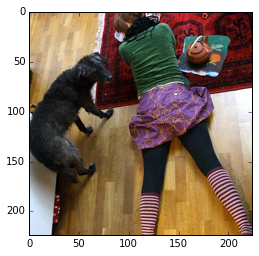

In [11]:
idx = numpy.random.randint(0, len(valid[0])) # random image
k = 1 # beam width
use_gt = False # set to False if you want to use the generated sample
gt = valid[0][idx][0] # groundtruth
context = numpy.array(valid[1][valid[0][idx][1]].todense()).reshape([14*14, 512]) # annotation
img = LoadImage(image_path+flist[valid[0][idx][1]])
plt.imshow(img)
plt.show()

In [12]:
if not use_gt:
    sample, score = gen_sample(tparams, f_init, f_next, context, 
                                      options, trng=trng, k=10, maxlen=200, stochastic=False)
    sidx = numpy.argmin(score)
    caption = sample[sidx][:-1]
    #print sidx
    for c in sample:
        words = map(lambda w: word_idict[w] if w in word_idict else '<UNK>', c[:-1])
        #print ' '.join(words)

[64, 20, 139, 295, 7, 6, 52, 0]
[64, 10, 2, 162, 26, 10, 712, 7, 6, 52, 0]
[64, 10, 2, 162, 26, 10, 712, 4, 6, 52, 0]
[64, 20, 139, 295, 4, 6, 52, 39, 6, 84, 3, 0]
[64, 10, 2, 162, 7, 6, 52, 39, 2, 70, 3, 0]
[64, 20, 139, 295, 4, 6, 52, 39, 6, 271, 3, 0]
[64, 10, 2, 162, 7, 6, 52, 21, 12, 2, 70, 3, 0]
[64, 10, 2, 162, 7, 6, 52, 21, 12, 2, 1586, 3, 0]
[64, 10, 2, 162, 7, 6, 52, 21, 12, 2, 344, 3, 0]
[64, 10, 2, 162, 7, 6, 52, 21, 12, 2, 30, 70, 3, 0]


In [15]:
# print the generated caption and the ground truth
print flist[valid[0][idx][1]]
if use_gt:
    caption = map(lambda w: worddict[w] if worddict[w] < options['n_words'] else 1, gt.split())
words = map(lambda w: word_idict[w] if w in word_idict else '<UNK>', caption)
print 'Sample:', ' '.join(words)
print 'GT:', gt

COCO_val2014_000000262509.jpg
Sample: there are many boats in the water
GT: a city scene that was seen from the other side of a river .


# alpha = f_alpha(numpy.array(caption).reshape(len(caption),1), 
                numpy.ones((len(caption),1), dtype='float32'), 
                context.reshape(1,context.shape[0],context.shape[1]))
if options['selector']:
    sels = f_sels(numpy.array(caption).reshape(len(caption),1), 
                   numpy.ones((len(caption),1), dtype='float32'), 
                   context.reshape(1,context.shape[0],context.shape[1]))
    
print alpha
print sels

## Displaying the Visualization   

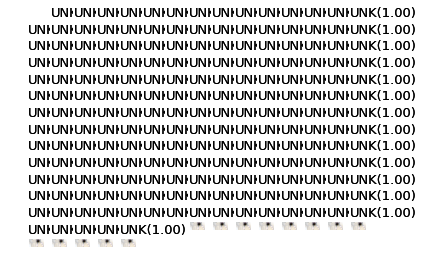

In [ ]:
# display the visualization
n_words = alpha.shape[0] + 1
w = numpy.round(numpy.sqrt(n_words))
h = numpy.ceil(numpy.float32(n_words) / w)
        
plt.subplot(w, h, 1)
plt.imshow(img)
plt.axis('off')

smooth = True

%matplotlib tk

for ii in xrange(alpha.shape[0]):
    plt.subplot(w, h, ii+2)
    lab = words[ii]
    if options['selector']:
        lab += '(%0.2f)'%sels[ii]
    plt.text(0, 1, lab, backgroundcolor='white', fontsize=13)
    plt.text(0, 1, lab, color='black' if sels[ii] > 0.1 else 'red', fontsize=13)
    plt.imshow(img)
    if smooth:
        alpha_img = skimage.transform.pyramid_expand(alpha[ii,0,:].reshape(14,14), upscale=16, sigma=20)
    else:
        alpha_img = skimage.transform.resize(alpha[ii,0,:].reshape(14,14), [img.shape[0], img.shape[1]])
    plt.imshow(alpha_img, alpha=0.8)
    plt.set_cmap(cm.Greys_r)
    plt.axis('off')
plt.show()

## Create test data ##

In [86]:
import pandas as pd
import numpy as np
import os
import scipy
import json
import cPickle
from sklearn.feature_extraction.text import CountVectorizer
import pdb

annotation_path = '/home/flipvanrijn/Downloads/results_20130124.token'
vgg_deploy_path = '/home/flipvanrijn/Workspace/Dedicon-Thesis/models/VGG_ILSVRC_19_layers_truncated_deploy.prototxt'
vgg_model_path  = '/home/flipvanrijn/Workspace/Dedicon-Thesis/models/VGG_ILSVRC_19_layers.caffemodel'
flickr_image_path = '/some/path/'

annotations = pd.read_table(annotation_path, sep='\t', header=None, names=['image', 'caption'])
annotations['image_num'] = annotations['image'].map(lambda x: x.split('#')[1])
annotations['image'] = annotations['image'].map(lambda x: os.path.join(flickr_image_path,x.split('#')[0]))

captions = annotations['caption'].values

vectorizer = CountVectorizer().fit(captions)
dictionary = vectorizer.vocabulary_
dictionary_series = pd.Series(dictionary.values(), index=dictionary.keys()) + 2
dictionary = dictionary_series.to_dict()

'''
with open('data/flickr30k/dictionary.pkl', 'wb') as f:
    cPickle.dump(dictionary, f)
'''
images = pd.Series(annotations['image'].unique())
image_id_dict = pd.Series(np.array(images.index), index=images)

caption_image_id = annotations['image'].map(lambda x: image_id_dict[x]).values
cap = zip(captions, caption_image_id)

# split up into train, test, and dev
all_idx = range(len(images))
np.random.shuffle(all_idx)
train_idx  = all_idx[0:25000]
test_idx = all_idx[25000:30000]
dev_idx = all_idx[30000:]

images_train = images[train_idx]
image_id_dict_train = image_id_dict[train_idx]
caption_image_id_train = caption_image_id[train_idx]
captions_train = captions[train_idx]
cap_train = zip(captions_train, caption_image_id_train)

In [102]:
caption_image_id_train

array([5354, 1908, 2540, ..., 6236, 1128, 1579])

In [104]:
images[5354]

'/some/path/2375402652.jpg'

In [105]:
captions_train[0]

'A man wearing a red coat and a blue scarf sitting indoors .'